# A simple binary problem: is there a legal move or not?

This is a simplified version in which the model only answers the question whether there is at least one legal move or not.

In [1]:
import sys
sys.path.append(sys.path[0] + '/../cpp/bin')

import PyMorpionSolitaire

In [61]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange

## Data generation

This function plays one game at random until there are no more moves, stores the grid as `grid1`, then rewinds the game to an interemediate stage, and stores the resulting grid as `grid2`. The output of the function is a tensor containing the two grids. By construction the first grid has no legal moves and the second one has at least one legal move.

1/3 of the time the game is taken back to an arbitrary intermediate step.
The other 2/3 of the time we rewind the game by only one step, so that the network gets used to identify a single allowed move. If we did not do that the training process would result in a relatively high accuracy by only identifying some types of allowed moves instead of all of them.

In [4]:
def play_one_game(host = 0): # dummy argument needed for passing to pool.map
    game = PyMorpionSolitaire.Game5T('c');
    game.playAtRandom()
    grid1 = game.image()[48:144, 48:144]
    if np.random.randint(3) == 0:
        game.undo(np.random.randint(game.getScore() - 1) + 2)
    else:
        game.undo()
    grid2 = game.image()[48:144, 48:144]
    return np.stack((grid1, grid2))

Mini-batches contains a certain number of grids obtained in the way described above (computed in parallel to gain time), as well as a labels (0 for no legal moves, 1 for at least one legal move).

In [5]:
def generate_batch(batch_size = 200):
    x = []
    for _ in range(batch_size // 2):
        x.append(play_one_game())
    x = torch.tensor(np.concatenate(x)).float().unsqueeze(1)
    y = torch.tensor([0.,1.]).repeat(batch_size // 2).unsqueeze(1)
    return x, y

## Example

In [85]:
x, y = generate_batch()

In [86]:
x.shape, y.shape

(torch.Size([200, 1, 96, 96]), torch.Size([200, 1]))

In [88]:
def visualize(x):
    return Image.fromarray(~np.array(torch.squeeze(x)).astype(bool))    

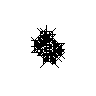

In [89]:
visualize(x[0])

In [90]:
y[0]

tensor([0.])

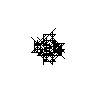

In [91]:
visualize(x[1])

In [92]:
y[1]

tensor([1.])

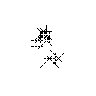

In [93]:
visualize(x[1] - x[0])

## Accuracy function

In [16]:
def accuracy(outputs, labels):
    return ((outputs > 0.5) == labels).float().mean()

## Model

In [49]:
net = torch.nn.Sequential(
#     torch.nn.Conv2d(1, 40, stride = 3, kernel_size = 13, padding = 2),
    torch.nn.Conv2d(1, 40, stride = 3, kernel_size = 15, padding = 0),
    torch.nn.AdaptiveMaxPool2d(1),
    torch.nn.Flatten(),
    torch.nn.Linear(40, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 2),
    torch.nn.ReLU(),
    torch.nn.Linear(2, 1)
)

Number of parameters in the model:

In [50]:
sum(p.numel() for p in net.parameters())

9217

In [51]:
y_pred = net(x)
y_pred.shape

torch.Size([200, 1])

In [53]:
accuracy(y_pred, y)

tensor(0.5000)

## Training

In [55]:
loss_func = torch.nn.MSELoss()

In [54]:
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.005)

optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.005, momentum=0.9)

In [ ]:
running_loss_data = []
running_accuracy_data = []

In [58]:
epoch_size = 100
n_epochs = 100

running_loss = []
running_accuracy = []

for i in trange(n_epochs * epoch_size + 1):
    inputs, labels = generate_batch()
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = loss_func(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss.append(loss.item())
    running_accuracy.append(accuracy(outputs, labels))
    if i % epoch_size == 0:
        running_loss_data.append(np.mean(running_loss))
        running_accuracy_data.append(np.mean(running_accuracy))
        print('[%6d] loss: %8.5f  accuracy: %4.2f' % (i, running_loss_data[-1], running_accuracy_data[-1]))
        running_loss = []
        running_accuracy = []

  0%|          | 0/10001 [00:00<?, ?it/s]

[     0] loss:  0.21972  accuracy: 0.62
[   100] loss:  0.21421  accuracy: 0.65
[   200] loss:  0.21074  accuracy: 0.66
[   300] loss:  0.21023  accuracy: 0.66
[   400] loss:  0.20785  accuracy: 0.67
[   500] loss:  0.20626  accuracy: 0.67
[   600] loss:  0.20308  accuracy: 0.68
[   700] loss:  0.20357  accuracy: 0.68
[   800] loss:  0.20148  accuracy: 0.68
[   900] loss:  0.20012  accuracy: 0.69
[  1000] loss:  0.19882  accuracy: 0.69
[  1100] loss:  0.19687  accuracy: 0.70
[  1200] loss:  0.19620  accuracy: 0.70
[  1300] loss:  0.19515  accuracy: 0.70
[  1400] loss:  0.19410  accuracy: 0.70
[  1500] loss:  0.19266  accuracy: 0.71
[  1600] loss:  0.19056  accuracy: 0.71
[  1700] loss:  0.18731  accuracy: 0.72
[  1800] loss:  0.18581  accuracy: 0.72
[  1900] loss:  0.18444  accuracy: 0.73
[  2000] loss:  0.18258  accuracy: 0.73
[  2100] loss:  0.18177  accuracy: 0.73
[  2200] loss:  0.17833  accuracy: 0.75
[  2300] loss:  0.17587  accuracy: 0.75
[  2400] loss:  0.17201  accuracy: 0.76


In [59]:
# torch.save(net, 'models/Democritus.pt')

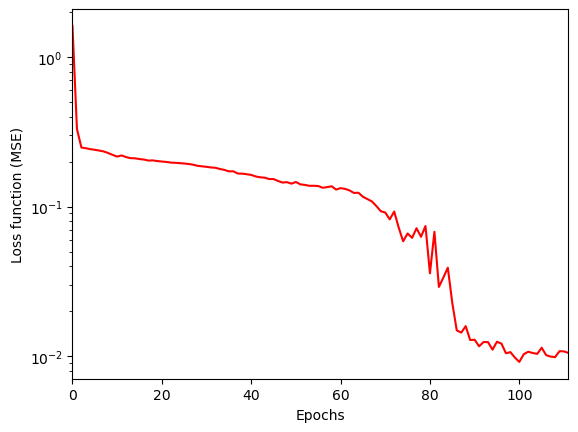

In [68]:
plt.plot(running_loss_data, color='red')
plt.xlabel('Epochs')
plt.xlim(0, len(running_loss_data) - 1)
plt.ylabel('Loss function (MSE)')
plt.yscale('log')
# plt.savefig('Democritus_loss.png', bbox_inches='tight')
plt.show()

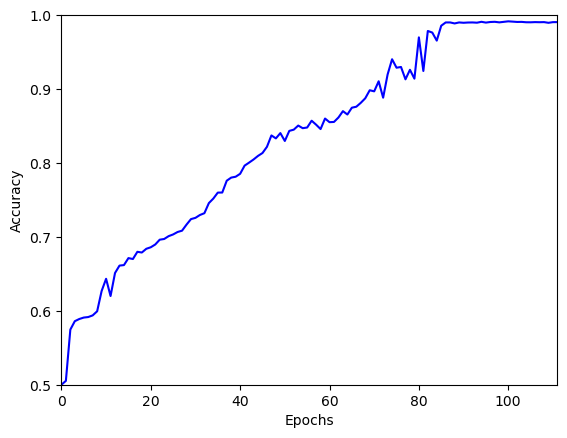

In [71]:
plt.plot(running_accuracy_data, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xlim(0, len(running_accuracy_data) - 1)
plt.ylim(0.5, 1)
# plt.savefig('Democritus_accuracy.png', bbox_inches='tight')
plt.show()

In [74]:
running_error_data = [1.0 - x for x in running_accuracy_data]

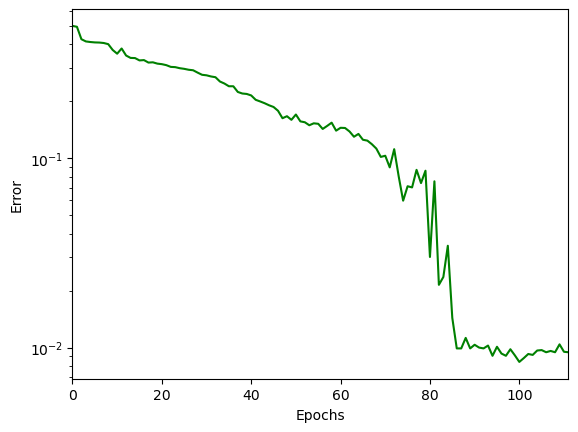

In [140]:
plt.plot(running_error_data, color='green')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.xlim(0, len(running_error_data) - 1)
plt.yscale('log')
plt.show()

## Loading the model

Once the model has been trained, this can be used to load its state dictionary:

In [77]:
net = torch.load('models/Democritus.pt')
net.eval()

Sequential(
  (0): Conv2d(1, 40, kernel_size=(15, 15), stride=(3, 3))
  (1): AdaptiveMaxPool2d(output_size=1)
  (2): Flatten(start_dim=1, end_dim=-1)
  (3): Linear(in_features=40, out_features=4, bias=True)
  (4): ReLU()
  (5): Linear(in_features=4, out_features=2, bias=True)
  (6): ReLU()
  (7): Linear(in_features=2, out_features=1, bias=True)
)

## Validation

In [78]:
x, y = generate_batch(1000)

In [79]:
y_preds = net(x).data

In [80]:
accuracy(y_preds, y)

tensor(0.9910)

In [81]:
y.mean(), y.std(), y_preds.mean(), y_preds.std()

(tensor(0.5000), tensor(0.5003), tensor(0.4716), tensor(0.4647))

In [82]:
mistakes = []
for i in range(y.shape[0]):
    if (y_preds[i] > 0.5) != y[i]:
        mistakes.append([y[i].item(), y_preds[i].item(), i])
mistakes

[[0.0, 0.8252942562103271, 28],
 [0.0, 0.8256768584251404, 106],
 [0.0, 0.85272216796875, 148],
 [0.0, 0.8425812721252441, 286],
 [0.0, 0.879586398601532, 440],
 [0.0, 0.8495593667030334, 590],
 [0.0, 0.8502621650695801, 598],
 [0.0, 0.788440465927124, 808],
 [0.0, 0.8710340261459351, 916]]

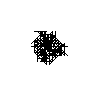

In [94]:
visualize(x[mistakes[0][2]])

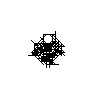

In [95]:
visualize(x[mistakes[1][2]])

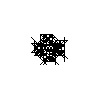

In [96]:
visualize(x[mistakes[2][2]])

To test the network we create a fake grid for which there should not be any possible move:

In [99]:
# testgrid = torch.zeros([1,1,94,94])
# testgrid[0,0, 48, 39:58] = torch.tensor([1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,1,1,1,1]).float()
# visualize(testgrid)

The answer of the network is however that there is a move

In [100]:
# net(testgrid)

## Network state

In [101]:
params = []
for param in net.parameters():
    params.append(param.data)
    print(param.size())

torch.Size([40, 1, 15, 15])
torch.Size([40])
torch.Size([4, 40])
torch.Size([4])
torch.Size([2, 4])
torch.Size([2])
torch.Size([1, 2])
torch.Size([1])


In [102]:
def divisors(x):
    i = np.round(np.sqrt(x)).astype(int)
    for j in range(i - 1):
        if x % (i - j) == 0:
            n = x // (i - j)
            return (n, x // n)
    return (x, 1)

In [ ]:
# par = np.array(params[0].squeeze())
# par *= -1.0
# par = par - np.min(par)
# par = par / np.max(par)
# par = np.round(255 * par)
# w, h = divisors(par.shape[0])
# im = np.zeros((15 * h, 15 * w), dtype = int)
# for i in range(h):
#     for j in range(w):
#         im[15*i+1:15*i+14,15*j+1:15*j+14] = par[w*i + j]
# image = Image.fromarray(np.uint8(im), 'L').resize((w*60, h*60), resample=0, box=None)
# image

In [106]:
par.shape

(40, 3, 15, 15)

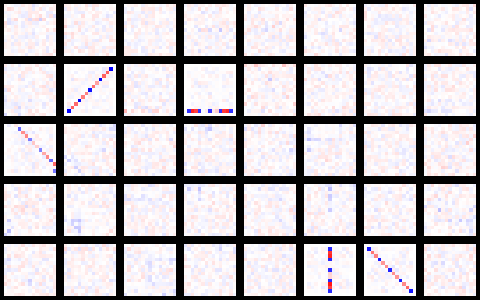

In [122]:
par = params[0].squeeze()
par /= torch.max(torch.abs(par))
blue = torch.tensor([1,1,0]).unsqueeze(1).unsqueeze(2)
red = torch.tensor([0,1,1]).unsqueeze(1).unsqueeze(2)
par = (blue * torch.where(par > 0, par, 0.0 * par).unsqueeze(1)
       + red * torch.where(par < 0, -1.0 * par, 0.0 * par).unsqueeze(1))
par = np.round(255 * par)
par = np.array(par).astype(int)
w, h = divisors(par.shape[0])
im = np.zeros((17 * h, 17 * w, 3), dtype = int)
for i in range(h):
    for j in range(w):
        for c in range(3):
            im[17*i+1:17*i+16,17*j+1:17*j+16,c] = 255 - par[w*i + j, c]
image = Image.fromarray(np.uint8(im), 'RGB').resize((w*60, h*60), resample=0, box=None)
image

In [ ]:
# image.save('Democritus_convlayer.png')

In [133]:
kernel = params[0][37].squeeze()
kernel.shape

torch.Size([15, 15])

In [134]:
segment = kernel[:,7]
segment

tensor([-0.0097,  0.8440, -0.7936, -0.8659,  0.8453, -0.0422, -0.0363,  0.8358,
        -0.1833, -0.1666,  0.8433, -0.9112, -0.7496,  0.8415, -0.0127])

In [138]:
val = segment * torch.tensor([0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0])
val = val.sum()
val

tensor(4.2100)

## Remarks

- Training with smaller mini-batches means quicker learning, but often saturation at accuracies way below 99%. With batch size 50 I got up to around 90% accuracy at best, with batch size 100 up to 95-98%.

- Most of the first layer is ends up unused, but working with fewer channels does not work: either some features are missing in the end, resulting in low accuracy, or the neural net gets stuck in a state where it always returns 0.5 after the first few training steps, yielding a loss function 0.25 and accuracy 0.5. 